# Merfish data playground

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import numpy as np
import scipy.interpolate
import seaborn
import matplotlib.pyplot as plt
import pandas as pd

from segmentation import SpotTable, run_baysor

In [3]:
os.getcwd()

'/home/luke/transcriptomics/spatial-analysis-wg/code/segmentation'

## Load merfish data, plot a subset of detected transcripts

In [4]:
csv_file = '../../../data/merscope_pilot/1191380492/detected_transcripts.csv'
cache_file = '../../../data/merscope_pilot/1191380492/detected_transcripts.npz'
table = SpotTable.load_merscope(csv_file, cache_file)

Loading from npz..


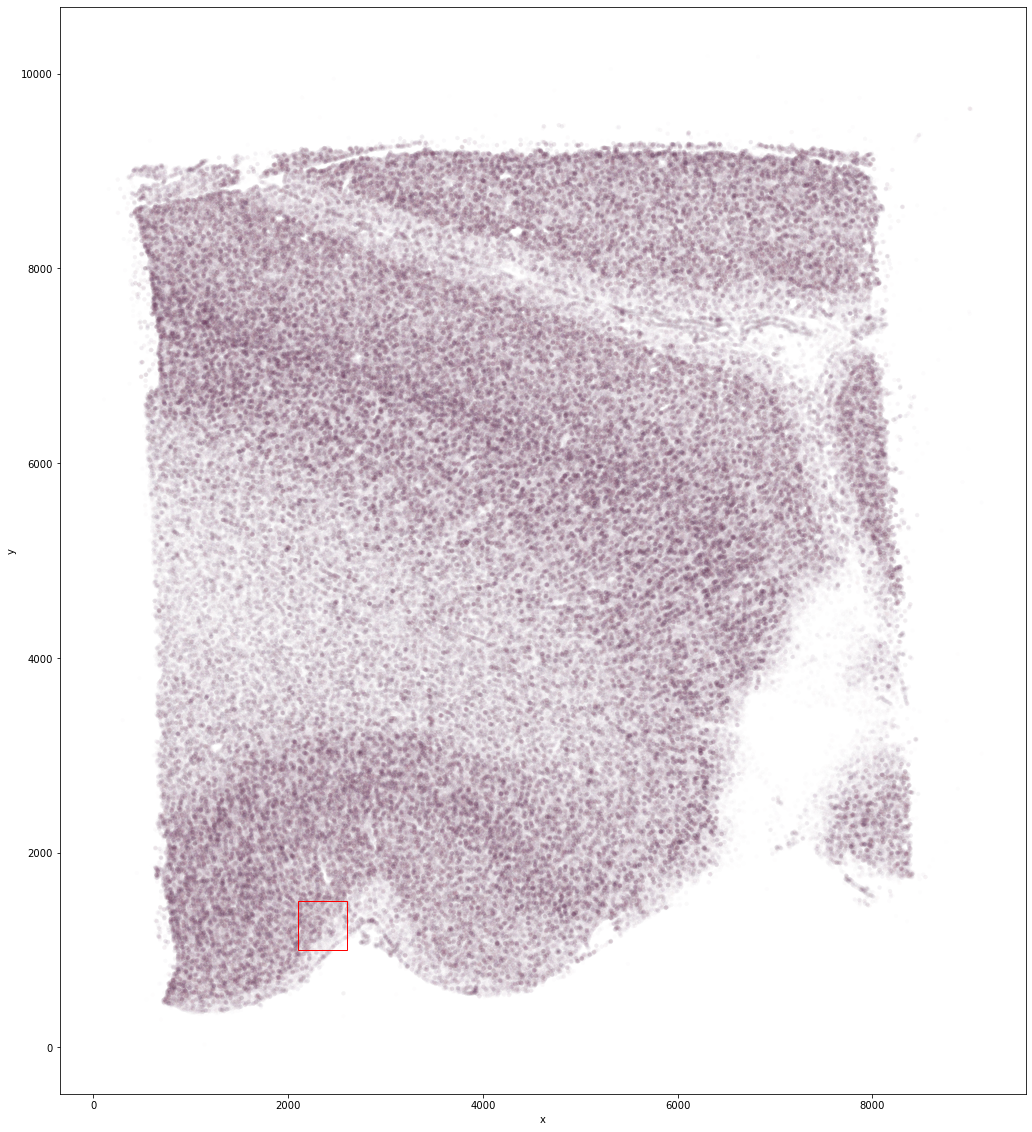

In [5]:
sub = table.get_subregion(xlim=(2100, 2600), ylim=(1000, 1500))

fig, ax = plt.subplots(figsize=(20, 20))
table[::100].scatter_plot(ax=ax, alpha=0.01)
sub.plot_rect(ax, 'r')

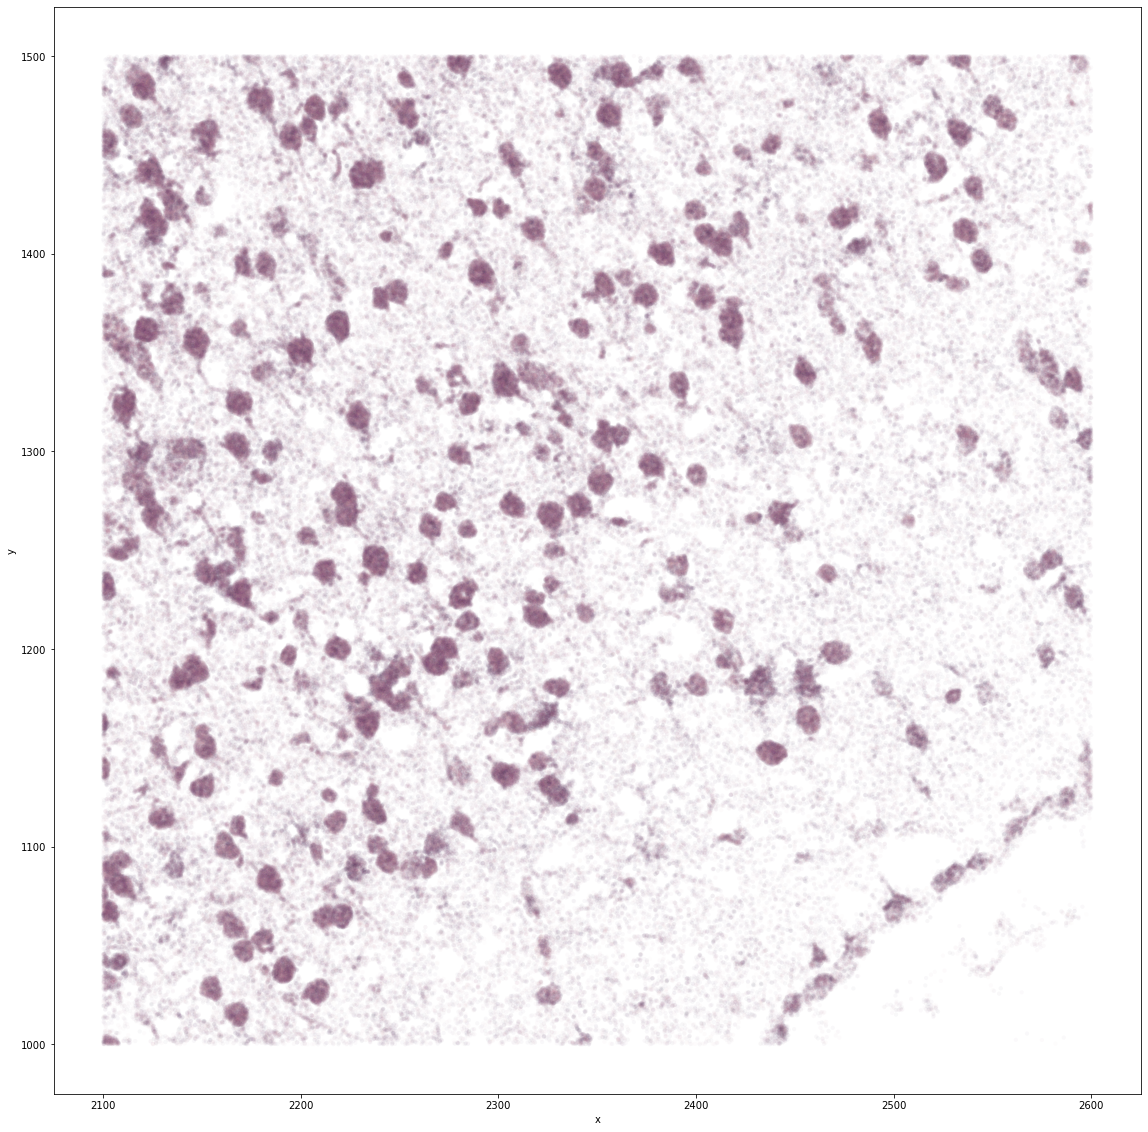

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
sub.scatter_plot(ax=ax, alpha=0.03)

## Generate maps colored by transcript expression levels

Approach:
- bin data into pixels
- sum up expression counts in each bin
- use umap to identify different types of expression patterns
- color each pixel based on position within umap

Binning expression counts..
Reducing binned expression counts..


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/luke/miniconda3/envs/transcriptomics/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


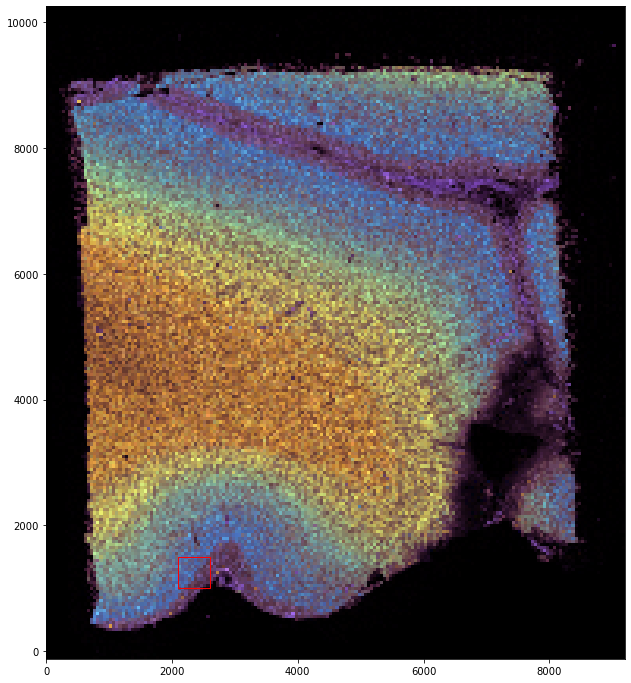

In [7]:
fig, ax = plt.subplots(figsize=(12,12))
table.reduced_expression_map(
    binsize=50, 
    umap_args=dict(
        min_dist=0.4,
        n_neighbors=10,
        random_state=0,
    ),
    ax=ax
);
sub.plot_rect(ax, 'r')

Binning expression counts..
Reducing binned expression counts..


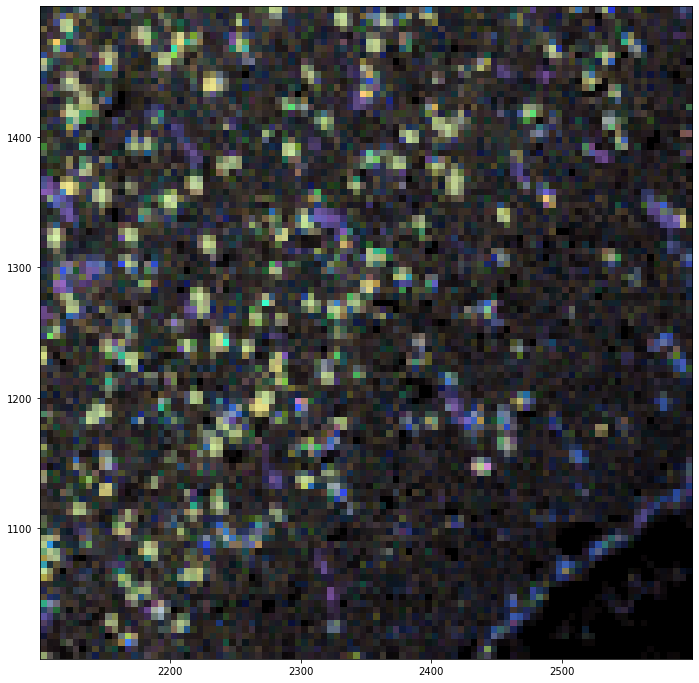

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
results2 = sub.reduced_expression_map(
    binsize=5, 
    umap_args=dict(
        min_dist=0.4,
        n_neighbors=10,
        random_state=0,
    ),
    ax=ax
)

Some general expression stats

In [9]:
data_df = table.dataframe(cols=['x', 'y', 'z', 'gene_names'])
data_df.rename(columns={'gene_names': 'gene'}, inplace=True)

In [10]:
data_df.head()

x            y    z    gene
0  299.709259  3361.122803  2.0   PI4KA
1  164.037155  3391.271240  1.0  FNBP1L
2  112.186668  3401.047852  1.0  FNBP1L
3  238.498306  3297.506592  2.0  FNBP1L
4  240.061310  3445.181396  3.0  FNBP1L

In [11]:
genes, counts = np.unique(table.gene_names, return_counts=True)

In [12]:
order = np.argsort(counts)
counts = counts[order]
genes = genes[order]

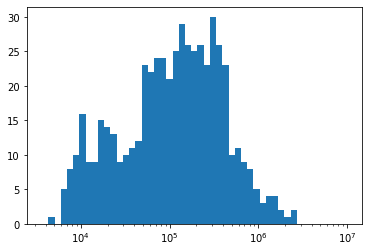

In [13]:
fig, ax = plt.subplots()
bins = 10**np.linspace(np.log10(counts.min()), np.log10(counts.max()), 50)
ax.hist(counts, bins=bins)
ax.set_xscale('log')

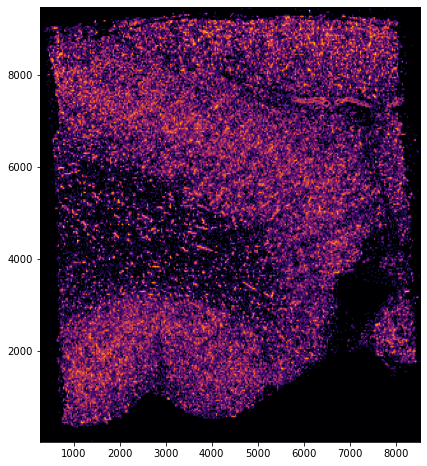

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
sub = table.get_genes(['RGS5'])
sub.show_image(ax)

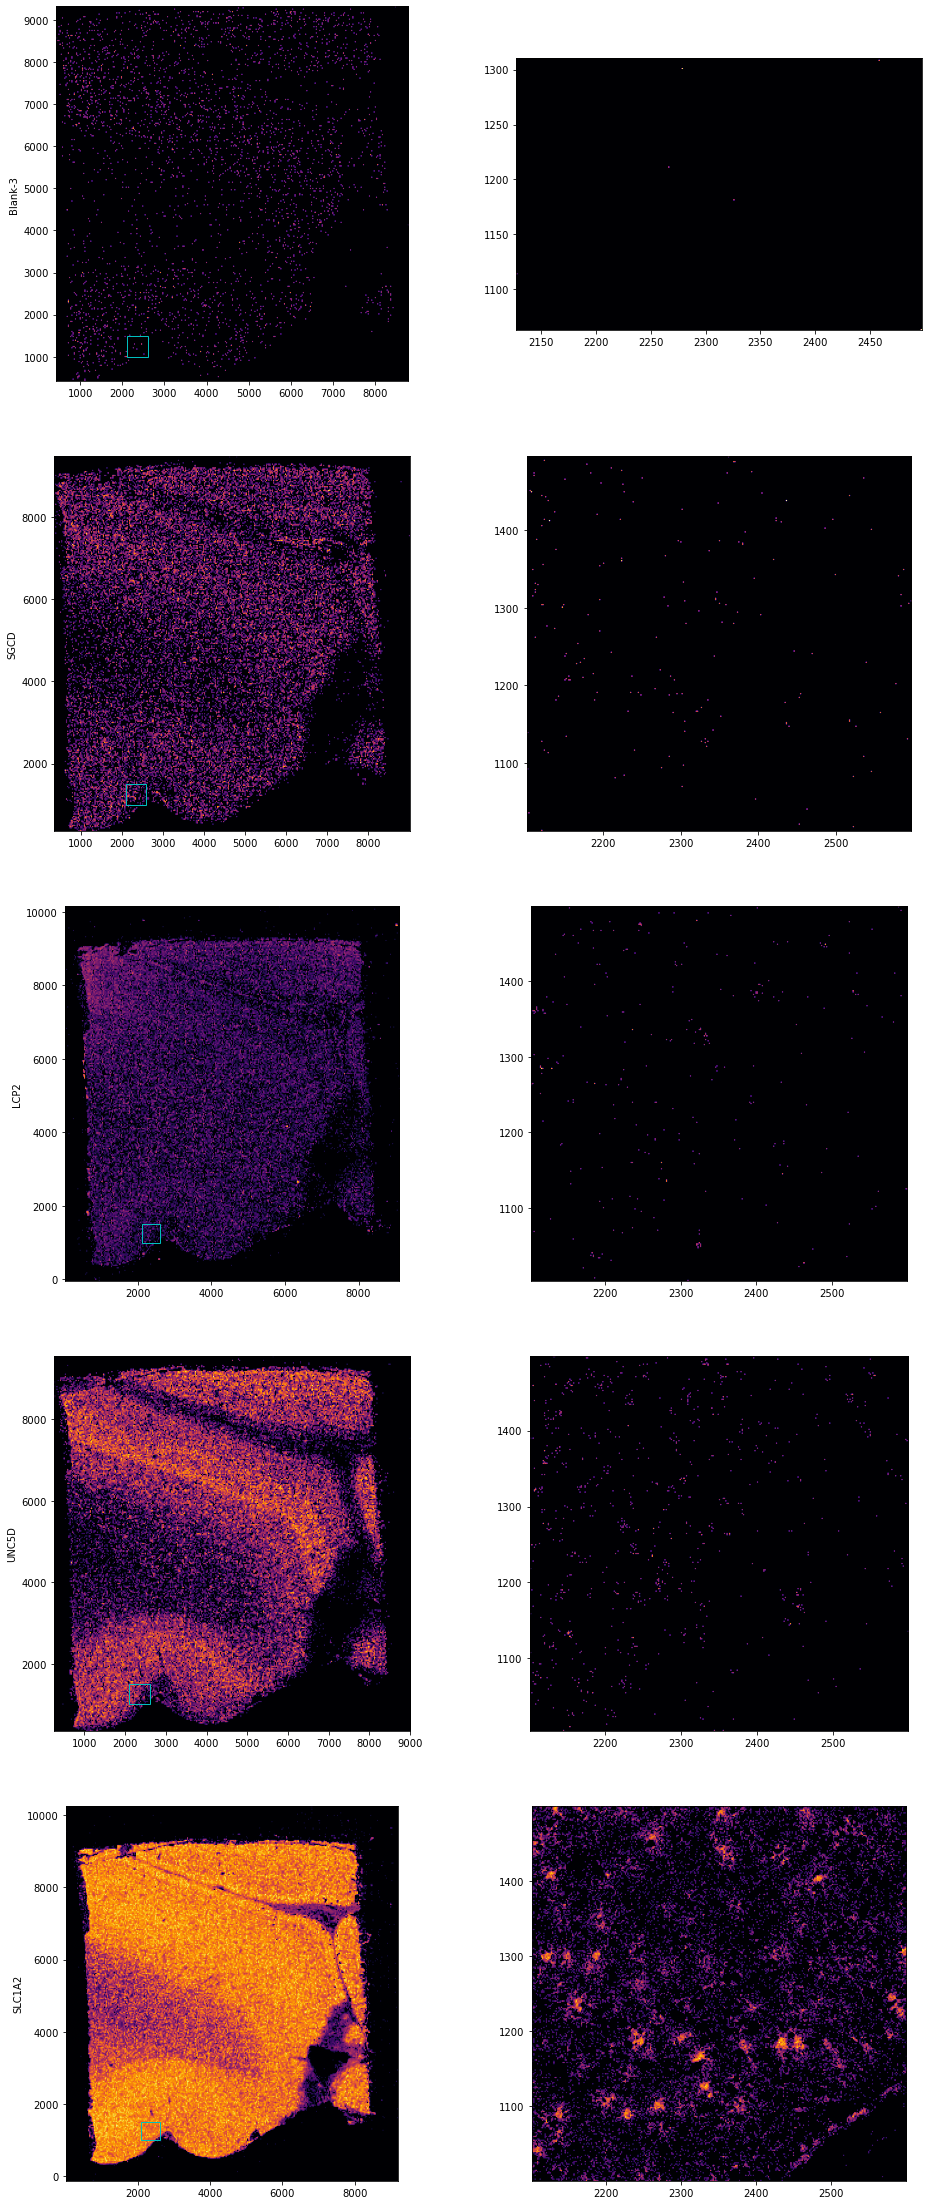

In [15]:
n_rows = 5
fig, ax = plt.subplots(n_rows, 2, figsize=(16, 8*n_rows))
for i in range(n_rows):
    gene_ind = i * (len(genes) - 1) // (n_rows - 1)
    gene = genes[gene_ind]
    sub1 = table.get_genes([gene])
    sub2 = sub1.get_subregion(xlim=(2100, 2600), ylim=(1000, 1500))
    sub1.show_subregion_images([sub2], ax[i])
    ax[i,0].set_ylabel(gene)


In [16]:
# generate histogram of spot locations for each gene
sub_table = table.get_subregion((1000, 4000), (400, 4000))
hist, (x_bins, y_bins, g_bins) = sub_table.binned_expression_counts(binsize=3)

In [17]:
hist.shape

(1000, 1200, 550)

In [30]:
import pyqtgraph.jupyter

In [ ]:
pyqtgraph.jupyter.

In [19]:
# norm_hist = hist[0] / hist[0].max(axis=1).max(axis=1)[:, None, None]
corr = (hist * hist.max(axis=0).max(axis=0)[None, None, :]).sum(axis=0).sum(axis=0)

In [21]:
order = corr.argsort()
ordered_corr = corr[order]
ordered_genes = g_bins[:-1][order]
ordered_names = table.map_gene_ids_to_names(ordered_genes)

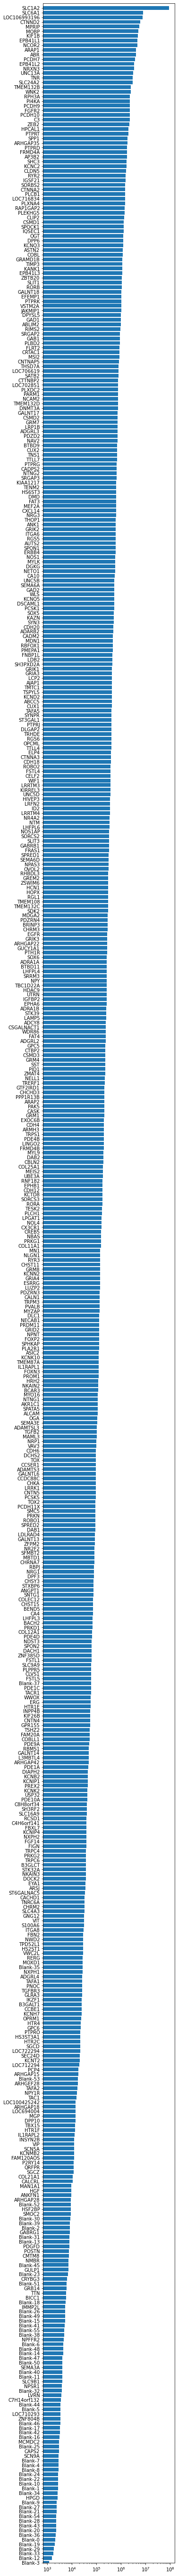

In [26]:
fig, ax = plt.subplots(figsize=(5, 100))
n_genes = len(ordered_corr)
yvals = np.arange(n_genes)
ax.barh(y=yvals, width=ordered_corr)

# ax.legend()
ax.set_ylim(0, n_genes)   
ax.set_yticks(yvals)
ax.set_yticklabels(ordered_names)
ax.set_xscale('log')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

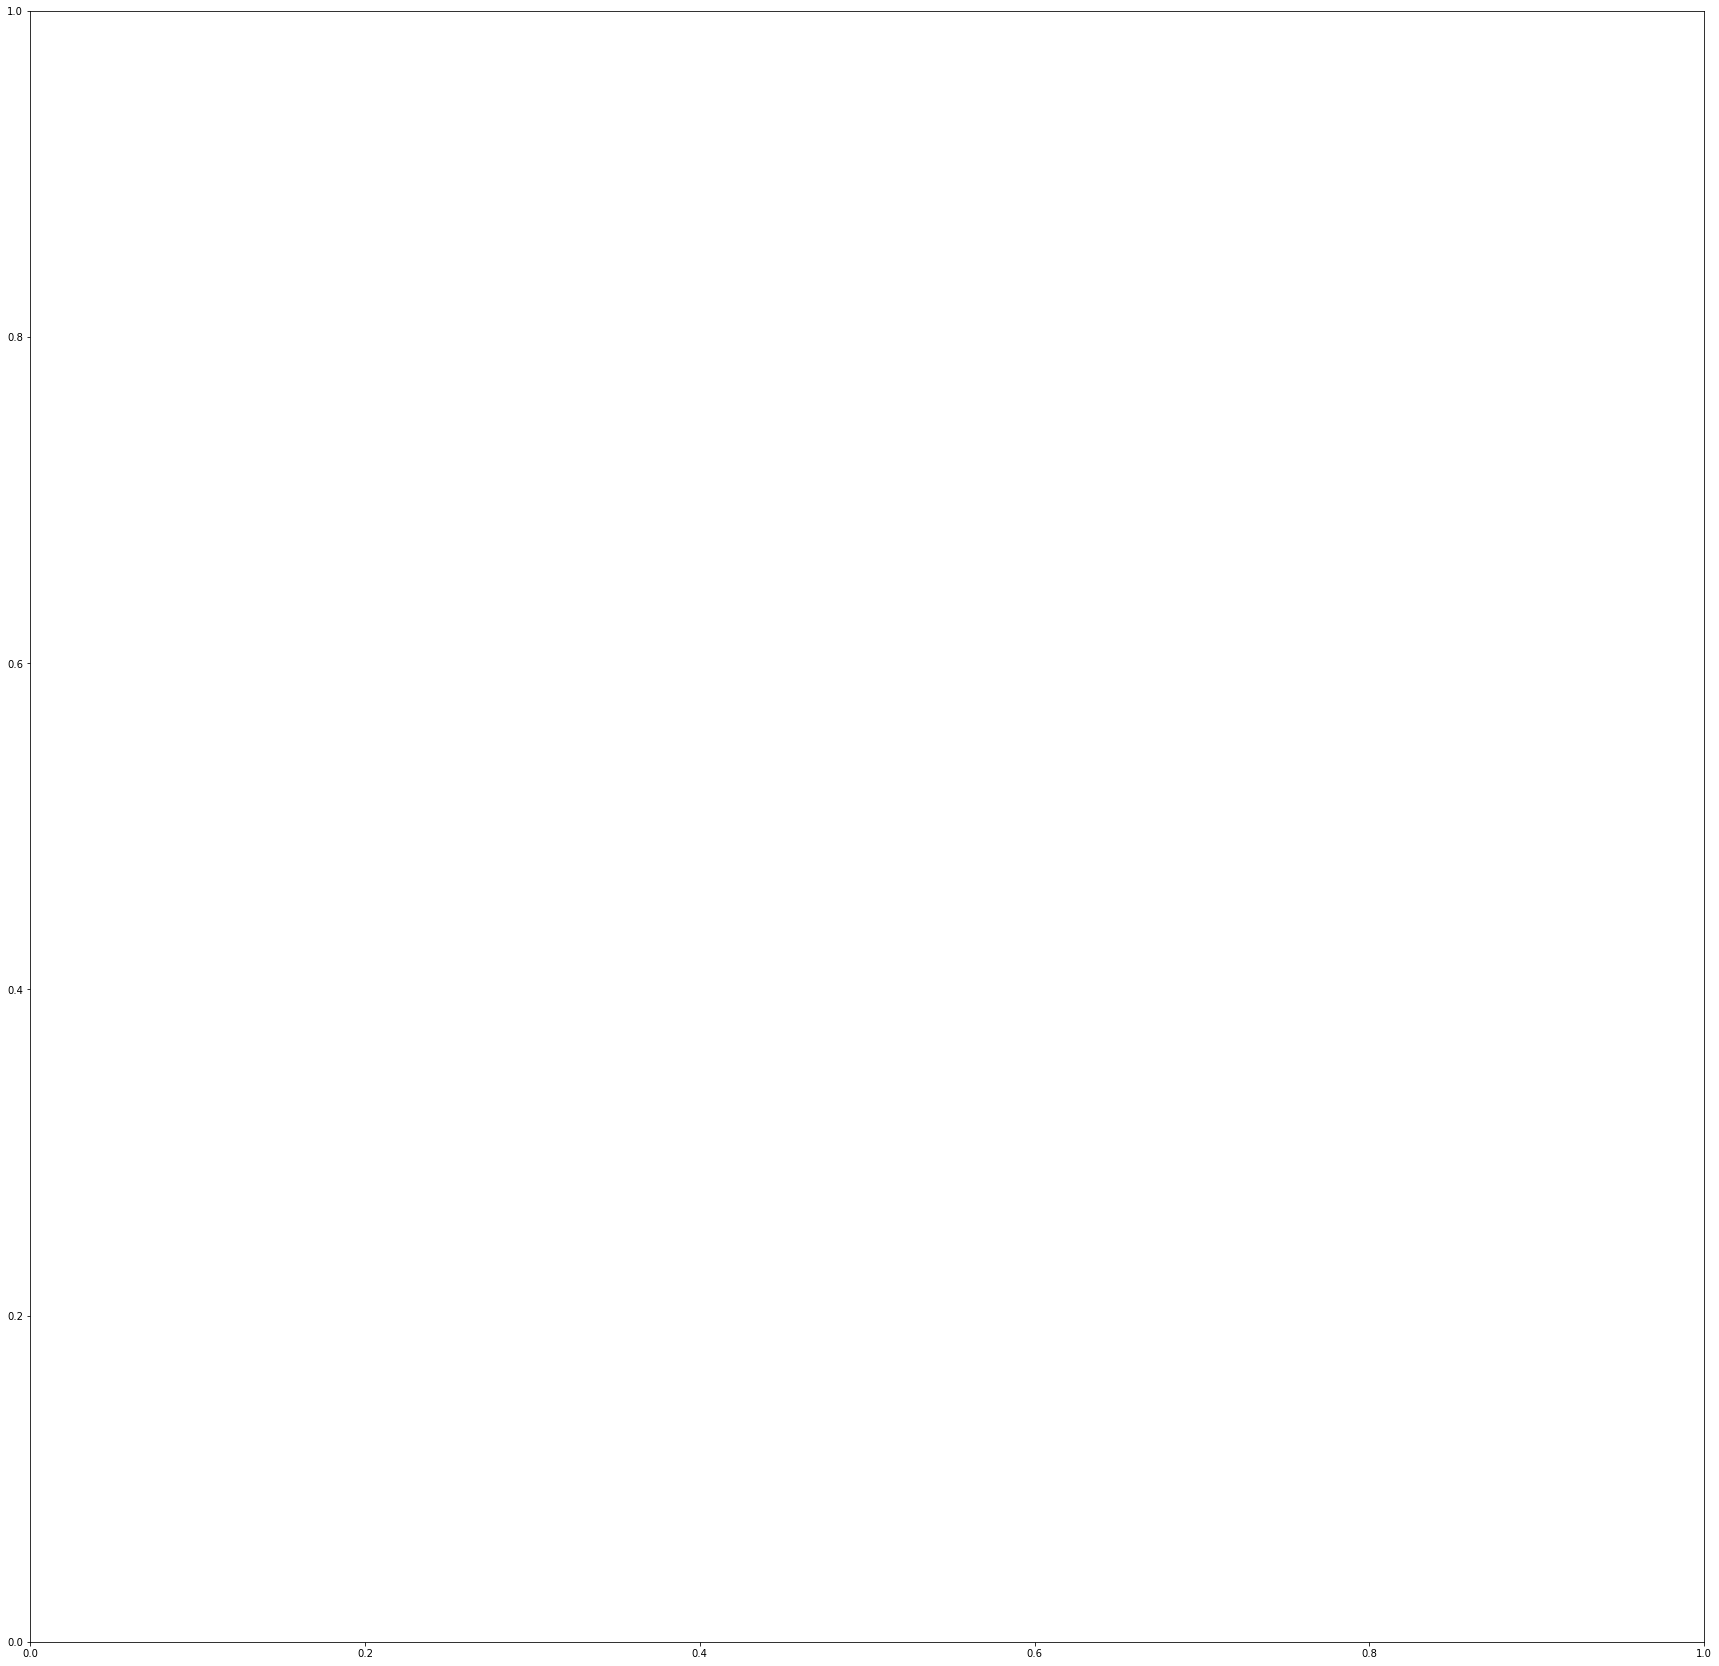

In [27]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.imshow(np.log(hist['ABR'].T + 1).astype(float), cmap='inferno')

In [ ]:
features = hist[0].reshape(hist[0].shape[0], hist[0].shape[1] * hist[0].shape[2])

In [ ]:
import sklearn

from sklearn.decomposition import MiniBatchSparsePCA

transformer = MiniBatchSparsePCA(n_components=5, batch_size=100, alpha=2, random_state=0)
transformer.fit(features)

import sklearn

from sklearn.decomposition import PCA

transformer = PCA(n_components=5, random_state=0)
transformer.fit(hist[0].reshape(hist[0].shape[0], hist[0].shape[1] * hist[0].shape[2]))

In [ ]:
transformer.components_.shape

In [ ]:
n_components = transformer.n_components
fig, ax = plt.subplots(n_components, figsize=(30, 10 * n_components))
for i in range(n_components):
    comp = transformer.components_[i].reshape(hist[0].shape[1:])
    comp = comp - np.median(comp)
    if comp.mean() < 0:
        comp = -comp
    comp = np.clip(comp, 0, np.inf)
    ax[i].imshow(np.log(comp.T[:300, :1000] + 1).astype(float), cmap='inferno')
    ax[i].set_aspect('equal')

In [ ]:
pc = transformer.transform(features)
pc.shape

In [ ]:
order = np.lexsort(np.abs(pc.T))
ordered_pc = pc[order]
ordered_genes = g_bins[:-1][order]
ordered_names = [table.gene_map[i].decode() for i in ordered_genes]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 100))

xvals = np.zeros(len(ordered_pc))
totals = np.abs(ordered_pc).sum(axis=1)
for i in range(pc.shape[1]):
    width = np.abs(ordered_pc[:, i]) / totals
    ax.barh(y=np.arange(len(ordered_pc)), left=xvals, width=width)
    xvals += width

# ax.legend()
ax.set_ylim(0, len(ordered_pc))    
ax.set_yticks(ordered_genes)
ax.set_yticklabels(ordered_names);

In [ ]:
sn_sums = pd.read_csv('../../../data/merscope_pilot/single_nucleus_gene_sums.csv')
sn_sums.rename(columns={'Unnamed: 0': 'gene', 'rowSums(sn_data)': 'total counts'}, inplace=True)
sn_sums.set_index('gene', inplace=True)
sn_sums.head()

In [ ]:
merfish_sums = data_df.groupby('gene').count()
merfish_sums.head()

In [ ]:
merfish_sums2 = merfish_sums['Unnamed: 0']
merfish_sums2 = pd.DataFrame(merfish_sums2).rename(columns={'Unnamed: 0': 'total counts'})
merfish_sums2.head()

In [ ]:
merge_counts = merfish_sums2.merge(sn_sums, left_index=True, right_index=True, suffixes=['_merfish', '_rnaseq'])
merge_counts.head()

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=merge_counts, x='total counts_merfish', y='total counts_rnaseq', ax=ax, alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
from scipy import stats

scorr = stats.spearmanr(merge_counts['total counts_merfish'].to_numpy(), merge_counts['total counts_rnaseq'].to_numpy(), nan_policy='omit')
scorr

In [ ]:
mask = merge_counts['total counts_rnaseq'].to_numpy() != 0

log_merfish = np.log(merge_counts['total counts_merfish'].to_numpy()[mask])
log_rnaseq = np.log(merge_counts['total counts_rnaseq'].to_numpy()[mask])

In [ ]:
stats.spearmanr(log_merfish, log_rnaseq)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(log_merfish.reshape(-1, 1), log_rnaseq)

model.score(log_merfish.reshape(-1, 1), log_rnaseq)

In [ ]:
model.coef_, model.intercept_

In [ ]:
def abline(slope, intercept, ax, color='k'):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', c=color)
    
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(log_merfish, log_rnaseq, alpha=0.7)
# ax.set_xscale('log')
# ax.set_yscale('log')

abline(model.coef_, model.intercept_, ax, color='orange')
abline(1, 0, ax, color='grey')

In [ ]:
merge_counts[merge_counts['total counts_rnaseq']==0] 

In [ ]:
cbg = pd.read_csv(data_path + 'cell_by_gene.csv')
cbg.rename(columns={'Unnamed: 0': 'cell'}, inplace=True)
cbg.set_index('cell', inplace=True)
cbg.head()

In [ ]:
cell_blank = cbg[[col for col in cbg.columns if col.startswith('Blank')]]
cell_blank.head()

In [ ]:
blanks_per_cell = cell_blank.sum(axis=1)
blanks_per_cell.describe()

In [ ]:
_ = plt.hist(blanks_per_cell)

In [ ]:
total_blanks = cell_blank.sum().to_numpy()
_ = plt.hist(total_blanks)
avg_blank = np.mean(total_blanks)
print(avg_blank)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=merge_counts, x='total counts_merfish', y='total counts_rnaseq', ax=ax, alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(avg_blank, ls='--', color='k')

In [ ]:
cell_gene = cbg[[col for col in cbg.columns if col.startswith('Blank')==False]]
cell_gene.head()

In [ ]:
cell_gene['n_genes'] = cell_gene.apply(lambda x: len(x[x>0]), axis=1)
cell_gene['n_spots'] = cell_gene.apply(lambda x: sum(x[x>0]), axis=1)

In [ ]:
cell_gene.head()

In [ ]:
cell_gene.describe()[['n_genes', 'n_spots']]

In [ ]:
cell_meta = pd.read_csv(data_path + 'cell_metadata.csv')
cell_meta.rename(columns={'Unnamed: 0': 'cell'}, inplace=True)
cell_meta.set_index('cell', inplace=True)
cell_meta.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=cell_meta, x='center_x', y='center_y', color='grey', ax=ax, s=5, alpha=0.3)

In [ ]:
cell_summary = cell_meta.merge(cell_gene[['n_genes', 'n_spots']], left_index=True, right_index=True)
volume = (cell_summary['volume']>100) & (cell_summary['volume']<3000)
genes = (cell_summary['n_genes']>15)
spots = (cell_summary['n_spots']>100)

filters = volume & genes

cell_filtered = cell_summary[filters]
cell_filtered['filtered'] = 'filtered'
cell_summary = cell_summary.append(cell_filtered)
cell_summary.fillna('all', inplace=True)
cell_summary.head()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.violinplot(data=cell_summary, x='filtered', y='volume', cut=0, ax=ax[0])
ax[0].axhline(100, ls='--', c='k')
ax[0].axhline(3000, ls='--', c='k')
sns.violinplot(data=cell_summary, x='filtered', y='n_genes', cut=0, ax=ax[1])
ax[1].axhline(15, ls='--', c='k')
ax[1].axhline(400, ls='--', c='k')
sns.violinplot(data=cell_summary, x='filtered', y='n_spots', cut=0, ax=ax[2])
ax[2].axhline(100, ls='--', c='k')
ax[2].axhline(3500, ls='--', c='k')
[axi.set_xlabel('cells') for axi in ax]
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=cell_meta, x='center_x', y='center_y', color='grey', ax=ax[0], s=5, alpha=0.3)
sns.scatterplot(data=cell_filtered, x='center_x', y='center_y', color='grey', ax=ax[1], s=5, alpha=0.3)